# Asset Allocation Strategies | Implementation & Analysis

### IEOR 4630: Asset Allocation
Professor: Yanwei Jia

Contributors:
* Mike Fu
* Emma Wensley
* Jeffrey Luo

**NOTE**: This notebook contains code that implements and runs a multitude of allocation strategies on available public equity data. The visualization of their performances is provided at the bottom of this notebook.

In [1]:
# Analysis
import pandas as pd
import numpy  as np
import cvxpy  as cp
import sklearn
from   sklearn.decomposition import PCA
import pandas_datareader as pdr
import statsmodels.api as sm

# Data import
import zipfile

# Visualization
import matplotlib.pyplot as plt

# Misc
from datetime import datetime as dtime, timedelta as tdelta
import os

pd.options.mode.chained_assignment = None  # default='warn'

### Unzip

In [2]:
full_path = os.getcwd()

Download historical stock prices from the following and place it within the repository file location: 

https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018

S&P500 weights obtained from: https://www.slickcharts.com/sp500 (04/07/2021)

In [3]:
# Extract stock prices from zip
zip_ref = zipfile.ZipFile(full_path + "/archive.zip", 'r')
zip_ref.extractall(full_path + "/data")
zip_ref.close()

### Cleaning + Creating Historical Stock Prices Dataframe

In [4]:
stock_prices_df  = pd.read_csv(
    full_path    + "/data/historical_stock_prices.csv",
    parse_dates  = ["date"],
    usecols      = ["date", "ticker", "adj_close"]
)

sp_500           = pd.read_csv(full_path + "/data/sp500.csv")
sp_500["weight"] = sp_500["weight"] / sp_500["weight"].sum()

In [5]:
# ==============
# Filter by date
# ==============
START_DATE_FILTER = dtime(2005,  1,  1)
END_DATE_FILTER   = dtime(2017, 12, 31)
stock_prices_df   = stock_prices_df[
    (stock_prices_df.date >= START_DATE_FILTER) &
    (stock_prices_df.date <=   END_DATE_FILTER)
]

# ================================================================================
# Filter to only include tickers that are present throughout the entire date range
# ~1926 tickers satisfy this criteria
# ================================================================================
total_dates       = len(stock_prices_df.date.unique())
stock_appearances = stock_prices_df.ticker.value_counts()
filtered_stock    = pd.DataFrame(
    data = {"ticker": stock_appearances[stock_appearances == total_dates].index}
)

stock_prices_df   = pd.merge(stock_prices_df, filtered_stock, on="ticker", how="inner")

### Raw Prices & Percentage Returns Dataframes

In [6]:
raw_prices       = stock_prices_df.pivot_table(index="date", columns=["ticker"], values="adj_close")
raw_prices       = raw_prices.drop(columns=["GOOGL"])
pct_returns      = raw_prices.pct_change().dropna()
pct_14d_returns  = pct_returns.resample("14D").sum()
universe_tickers = pct_returns.columns

### Statistical Calculations

Calculate covariance matrix ($\Sigma$) and inverse covariance matrix ($\Sigma^{-1}$) on stock log returns
Calculate volatility ($\sigma$) on stock log returns

In [7]:
def get_cov_pct_returns(tickers, start_date, end_date):
    tickers  = list(set(pct_returns.columns).intersection(tickers))
    filtered = pct_14d_returns[tickers][(start_date <= pct_14d_returns.index) & (pct_14d_returns.index <= end_date)]
    
    return (filtered - filtered.mean()).cov()

def get_std_pct_returns(tickers, start_date, end_date):
    tickers = list(set(pct_returns.columns).intersection(tickers))
    
    return pct_14d_returns[tickers][(start_date <= pct_14d_returns.index) & (pct_14d_returns.index <= end_date)].std()

### Uniform Weighting

Each stock is given a $1/N$ weight/allocation.

### Market Cap Weighting

Each stock is weighted according to their respective market cap (as of 2021). For simplicity, we assume that this market cap weighting has held since the beginning of the trading strategy. This will thus become overweight on stocks that have grown into large market cap, and may present over-optimistic portfolio performance.

In [8]:
def get_uniform_weights(tickers, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(sp_500.ticker).intersection(set(pct_returns.columns)))
    N          = len(tickers)
    
    ret_df = pd.DataFrame(
        index   = date_range,
        columns = tickers,
        data    = np.full((len(date_range), N), 1/N)
    )
    
    ret_df.index.name = "date"
    
    return ret_df

def get_market_cap_weights(start_date, end_date):
    date_range     = pd.date_range(start_date, end_date)
    ticker_weights = sp_500.pivot_table(columns="ticker", values="weight")
    tickers        = list(set(sp_500.ticker).intersection(set(pct_returns.columns)))
    weight_vec     = ticker_weights[tickers].values[0]
    shape          = (len(date_range), len(tickers))
    
    ret_df = pd.DataFrame(
        index   = date_range,
        columns = tickers,
        data    = np.tile(weight_vec, len(date_range)).reshape(shape)
    )
    
    ret_df.index.name = "date"
    
    return ret_df

### Maximum Diversification Weighting

Goal: Create portfolios that have minimally correlated assets, lower risk levels, and possibly higher returns.

(Introduced by Choueifaty and Coignard, 2008 and Pemberton & Rau, 2007)

The objective is to find the weight $w$ that maximizes the following:

$
\max_w \frac{w^T a}{\sqrt{w^T \Sigma w }}
$

We obtain the following short-selling allowed analytical solution:

$
w_{MD} = \frac{\Sigma^{-1} \sigma}{\sigma^T \Sigma^{-1} \sigma}
$

When restricting the weights to $w \geq 0$, we use `cvxpy` to solve the original convex optimization problem:

$
\min_w \frac{1}{2} w^T \Sigma w
$

s.t.
$
w^T \sigma = 1 \newline
w   \geq 0
$

In [9]:
def get_max_diverse_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    tickers     = list(set(universe_tickers).intersection(set(tickers)))
    ret_df      = pd.DataFrame(index = date_range, columns = tickers)
    
    # pct_returns_cov     = None
    # pct_returns_cov_inv = None
    # pct_returns_vol     = None
    max_diverse_weight  = None
    
    rebalance = False
    
    for date in date_range:
        
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            pct_returns_cov_inv = np.linalg.inv(pct_returns_cov)
            
            pct_returns_vol     = get_std_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            max_diverse_weight  = (pct_returns_cov_inv @ pct_returns_vol) / \
                                    (pct_returns_vol.T @ pct_returns_cov_inv @ pct_returns_vol)

        else: # No need to rebalance, just use previously calculated weights
            norm_factor         = np.sum(max_diverse_weight)
            max_diverse_weight  = max_diverse_weight / norm_factor
            ret_df.loc[date]    = max_diverse_weight
        
    return ret_df.dropna()

def get_max_diverse_long_only_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    tickers     = list(set(universe_tickers).intersection(set(tickers)))
    ret_df      = pd.DataFrame(index = date_range, columns = tickers)
    
    # Get weights from the respective convex optimization problem
    # min  w^T \Sigma w
    # s.t. w^T \sigma  = 1
    #      w          >= 0
    def get_weights(vol, cov_mat):
        w           = cp.Variable(len(vol))
        objective   = cp.Minimize(cp.quad_form(w, cov_mat))
        ones_vec    = np.ones(len(vol))
        constraints = [w >= 0, w.T @ ones_vec == 1]
        problem     = cp.Problem(objective, constraints)
        problem.solve()
        return w.value
    
    max_diverse_weight = None
    
    for date in date_range:
        
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            pct_returns_vol     = get_std_pct_returns(tickers, date + tdelta(days = -365),
                                                      date + tdelta(days = -1)).values
            
            # Solve the convex optimization problem each time
            max_diverse_weight  = get_weights(pct_returns_vol, pct_returns_cov)
            
        else: # No need to rebalance, just use previously calculated weights
            norm_factor         = np.sum(max_diverse_weight)
            max_diverse_weight  = max_diverse_weight / norm_factor
            ret_df.loc[date]    = max_diverse_weight
            
    return ret_df.dropna()

### Global Minimum Variance

The GMV portfolio is the lowest risk portfolio on the efficient frontier.

It solves the following optimization problem:

$
min_w w^T \Sigma w
$

s.t. $w^T 1 = 1$

The analytical solution is as follows:

$w^* = \frac{\Sigma^{-1} 1} {1^T \Sigma^{-1} 1}$

In [10]:
def get_gmv_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    tickers     = list(set(universe_tickers).intersection(set(tickers)))
    ret_df      = pd.DataFrame(index = date_range, columns = tickers)
    gmv_weight  = None
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), date + tdelta(days = -1)).values      
            pct_returns_cov_inv = np.linalg.inv(pct_returns_cov)
            ones_vec            = np.ones(len(tickers))
            gmv_weight          = pct_returns_cov_inv @ ones_vec / (ones_vec.T @ pct_returns_cov_inv @ ones_vec)
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date]    = gmv_weight
            
    return ret_df.dropna()

### Statistical Factor Model
At a specific time $t$ for which the portfolio is to be rebalanced, for each asset $k$, we try to find the asset's exposure to each factor via OLS:

$
R_k(t) = \alpha_k + \sum_i^{n} \beta_{ki} f_i(t) = \alpha_k + \beta_{k1} f_1 + \beta_{k2} f_2 + ... + \beta_{kn} f_n
$

We will estimate the coefficients $\beta_{ki} \forall i$ for a given asset $k$.

In [11]:
def get_factor_analysis_weights(tickers, start_date, end_date, rebalance_days, num_factors: int = 6):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(universe_tickers).intersection(set(tickers)))
    ret_df     = pd.DataFrame(index = date_range, columns = tickers)
    fa_weight  = None
    
    filtered_pct_returns = pct_returns[tickers]
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            
            pca = PCA(n_components = num_factors)
            pca.fit(filtered_pct_returns[:date + tdelta(days=-1)])

            # Each column vector / eigenvector is a factor loading
            eigenvecs         = pca.components_.T
            factor_loadings   = pca.components_.T

            # Apply dimensionality reduction
            factor_returns = pca.fit_transform(filtered_pct_returns[:date + tdelta(days=-1)])
            cov_factor     = np.cov(np.transpose(factor_returns))
            mu             = pca.mean_

            # Constructing the matrix D
            reconstructed_returns = factor_returns @ factor_loadings.T + mu.T
            unexplained_returns   = filtered_pct_returns[:date + tdelta(days=-1)] - reconstructed_returns
            unexplained_variance  = np.diag(np.cov(unexplained_returns.T))
            D                     = np.diag(unexplained_variance)

            w  = cp.Variable(len(filtered_pct_returns.columns)) # weight
            fw = cp.Variable(num_factors) # factor weight
            e  = np.ones(len(filtered_pct_returns.columns))

            target_risk = 0.0001

            # Solve convex optimization problem 
            # =================================
            # Details here: https://www.mathworks.com/help/finance/portfolio-optimization-using-factor-models.html
            objective   = cp.Maximize(mu.T @ w)
            constraints = [
                cp.quad_form(fw, cov_factor) + cp.quad_form(w, D) <= target_risk,
                w.T @ e == 1,
                factor_loadings.T @ w == fw,
                w >= 0,
            ]

            prob = cp.Problem(objective, constraints)
            prob.solve()
            
            # Recalibrate weight on rebalance day
            fa_weight = w.value
        
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date] = fa_weight
            
    return ret_df.dropna()

### Fama French Model

In [12]:
def get_fama_weights(tickers, start_date, end_date, rebalance_days):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(universe_tickers).intersection(set(tickers)))
    ret_df     = pd.DataFrame(index = date_range, columns = tickers)
    fa_weight  = None
    
    filtered_pct_returns = pct_returns[tickers]
    stock_prices_df_wide = raw_prices[tickers]
    
    num_factors = 6
    
    fama_french    = pdr.data.DataReader(
        "F-F_Research_Data_5_Factors_2x3", 
        "famafrench", 
        start="2005-01-01" # start_date.strftime("%Y-%m-%d"))[0]
    )[0]
    
    df_ff          = fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] / 100
    df_ff          = df_ff.resample('D').mean().ffill()
    df_ff.index    = df_ff.index.astype('datetime64[ns]')
    df_ff          = df_ff.loc[stock_prices_df_wide.index]
    
    df_ff['const'] = 1.0 # adds constant term
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            
            # lag the historical data to prevent lookahead
            curr_df_ff = df_ff[:date + tdelta(days=-1)]
            curr_stock_prices_df_wide = stock_prices_df_wide[:date + tdelta(days=-1)]
            curr_filtered_pct_returns = filtered_pct_returns[:date + tdelta(days=-1)]
            
    
            beta = pd.DataFrame()             # finds the factor exposures to 
            for sym in curr_stock_prices_df_wide.columns:
                model = sm.OLS(curr_stock_prices_df_wide[sym], curr_df_ff)
                results = model.fit()
                beta = pd.concat([beta, pd.DataFrame([results.params], index=[sym])])
            
            # invest in stocks with more than 2 positive exposures to the fama french
            w = (((beta.iloc[:, :5] > 0).sum(axis=1)) > 2)
            w *= (1 / w.sum())
        
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date] = w
            
    return ret_df #.dropna()

### Moving Average Convergence Divergence (MACD), Stochastic, and Combined Strategies (Returns performance directly)

See https://www.investopedia.com/articles/trading/08/macd-stochastic-double-cross.asp for more information on this strategy.

In [13]:
def get_macd_position(tickers):
    tickers              = list(set(universe_tickers).intersection(set(tickers)))
    stock_prices_df_wide = raw_prices[tickers]
    ema12                = stock_prices_df_wide.ewm(span=12, adjust=False).mean()
    ema26                = stock_prices_df_wide.ewm(span=26, adjust=False).mean()
    macd                 = ema12 - ema26
    signal_line          = macd.ewm(span=9, adjust=False).mean() - macd
    macd_position        = (signal_line > 0).rolling(5).max()
    
    return macd_position

def get_macd_performance(tickers):
    tickers              = list(set(universe_tickers).intersection(set(tickers)))
    stock_prices_df_wide = raw_prices[tickers]
    macd_position        = get_macd_position(tickers)
    macd_daily_perf      = (stock_prices_df_wide.pct_change() * macd_position.shift(1)) \
                            .mean(axis=1).dropna()
    
    macd_cumulative_perf = np.exp(macd_daily_perf.cumsum())

    return macd_daily_perf, macd_cumulative_perf

def get_stochastic_position(tickers):
    tickers                  = list(set(universe_tickers).intersection(set(tickers)))
    stock_prices_df_wide     = raw_prices[tickers]
    stock_prices_df_wide_min = stock_prices_df_wide.rolling(window=14).min().shift(1)
    stock_prices_df_wide_max = stock_prices_df_wide.rolling(window=14).max().shift(1)
    stock_prices_df_wide_K   = 100 * ((stock_prices_df_wide - stock_prices_df_wide_min) / \
                                    (stock_prices_df_wide_max - stock_prices_df_wide_min) )
    stock_prices_df_wide_D   = stock_prices_df_wide_K.rolling(window=3).mean()
    
    #Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
    #A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
    # df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 
    stock_prices_df_wide_sell_entry = (stock_prices_df_wide_K < stock_prices_df_wide_D) \
        & (stock_prices_df_wide_K.shift(1) > stock_prices_df_wide_D.shift(1)) & (stock_prices_df_wide_D > 80) 

    #Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
    #A sell exit signal is given when the %K line crosses back up through the %D line 
    # df['Sell Exit'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) 
    stock_prices_df_wide_sell_exit = ((stock_prices_df_wide_K > stock_prices_df_wide_D) &\
                                      (stock_prices_df_wide_K.shift(1) < stock_prices_df_wide_D.shift(1))) 

    #create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
    stock_prices_df_wide_short = pd.DataFrame().reindex_like(stock_prices_df_wide_sell_exit)
    stock_prices_df_wide_short = stock_prices_df_wide_short.where(stock_prices_df_wide_sell_entry, -1)
    stock_prices_df_wide_short = stock_prices_df_wide_short.where(stock_prices_df_wide_sell_exit, 0)

    # #Set initial position on day 1 to flat 
    stock_prices_df_wide_short.iloc[0] = 0

    # #Forward fill the position column to represent the holding of positions through time 
    stock_prices_df_wide_short.fillna(method='pad')

    #Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
    #A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
    stock_prices_df_wide_buy_entry = ((stock_prices_df_wide_K > stock_prices_df_wide_D) &\
                       (stock_prices_df_wide_K.shift(1) < stock_prices_df_wide_D.shift(1))) &\
                        (stock_prices_df_wide_D < 20) 

    #Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
    #A buy exit signal is given when the %K line crosses back down through the %D line 
    stock_prices_df_wide_buy_exit = ((stock_prices_df_wide_K < stock_prices_df_wide_D) &\
                      (stock_prices_df_wide_K.shift(1) > stock_prices_df_wide_D.shift(1))) 

    # #create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
    stock_prices_df_wide_long = pd.DataFrame().reindex_like(stock_prices_df_wide_buy_exit)
    stock_prices_df_wide_long = stock_prices_df_wide_long.where(stock_prices_df_wide_buy_entry, 1)
    stock_prices_df_wide_long = stock_prices_df_wide_long.where(stock_prices_df_wide_buy_exit, 0)

    # #Set initial position on day 1 to flat 
    stock_prices_df_wide_long.iloc[0] = 0

    # #Forward fill the position column to represent the holding of positions through time 
    stock_prices_df_wide_long.fillna(method='pad')

    # #Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
    final_position = stock_prices_df_wide_long + stock_prices_df_wide_short
    
    return final_position

def get_stochastic_performance(tickers):
    tickers                        = list(set(universe_tickers).intersection(set(tickers)))
    stock_prices_df_wide           = raw_prices[tickers]
    stochastic_position            = get_stochastic_position(tickers)
    stochastic_osc_daily_perf      = (stock_prices_df_wide.pct_change() * stochastic_position.shift(1))\
                                        .mean(axis=1).dropna()
    stochastic_osc_cumulative_perf = np.exp(stochastic_osc_daily_perf.cumsum())

    return stochastic_osc_daily_perf, stochastic_osc_cumulative_perf

def get_combined_macd_stochastic_performance(tickers):
    tickers                  = list(set(universe_tickers).intersection(set(tickers)))
    stock_prices_df_wide     = raw_prices[tickers]
    macd_position            =  get_macd_position(tickers)       # macd
    stochastic_position      =  get_stochastic_position(tickers) # stochasitc
    combined_strategy        = np.sign(macd_position + stochastic_position.shift(1)) \
                                    * stock_prices_df_wide.pct_change()
    combined_cumulative_perf = np.exp(combined_strategy.cumsum().mean(axis=1))
    
    return combined_cumulative_perf

### Weight calculations

In [14]:
# Benchmarks / Naive Strategies


#######################
#  Uniform Weighting  #
#######################
unif_weights   = get_uniform_weights(
    tickers    = sp_500.ticker,
    start_date = dtime(2007, 1, 1), 
    end_date   = dtime(2017, 12, 31)
)

##########################
#  Market Cap Weighting  #
##########################
sp500_weights  = get_market_cap_weights(
    start_date = dtime(2007, 1, 1),
    end_date   = dtime(2017, 12, 31)
)

In [16]:
# Max Diversification

#################################################
#  Max Diversification (Short-selling Allowed)  #
#################################################
max_diverse_weights = get_max_diverse_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

#####################################
#  Max Diversification (Long Only)  #
#####################################
max_diverse_long_only_weights = get_max_diverse_long_only_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

In [17]:
# Factor-based Strategies

##############################
#  Statistical Factor Model  #
##############################
fa_weights = get_factor_analysis_weights(
    tickers        = list(sp_500.ticker[-15:]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

#################
#  Fama French  #
#################
fama_weights = get_fama_weights(
    tickers        = list(sp_500.ticker[:100]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

In [18]:
# Mean-Variance Efficient Strategies


###################################
#  Global Minimum Variance (GMV)  #
###################################
gmv_weights = get_gmv_weights(
    tickers        = list(sp_500.ticker[300:315]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

### Benchmark + Traditional Strategy Execution

In [19]:
def execute_strategy_v2(weights):
    daily_returns               = (pct_returns[weights.columns] * weights).dropna()
    daily_portfolio_pct_returns = daily_returns.sum(axis=1)
    return daily_portfolio_pct_returns, np.cumprod(daily_portfolio_pct_returns + 1)

unif_daily_perf,                  unif_cumulative_perf                  = execute_strategy_v2(unif_weights)
sp500_daily_perf,                 sp500_cumulative_perf                 = execute_strategy_v2(sp500_weights)
max_diverse_daily_perf,           max_diverse_cumulative_perf           = execute_strategy_v2(max_diverse_weights)
max_diverse_long_only_daily_perf, max_diverse_long_only_cumulative_perf = execute_strategy_v2(max_diverse_long_only_weights)
gmv_daily_perf,                   gmv_cumulative_perf                   = execute_strategy_v2(gmv_weights)
fa_daily_perf,                    fa_cumulative_perf                    = execute_strategy_v2(fa_weights)
fama_daily_perf,                  fama_cumulative_perf                  = execute_strategy_v2(fama_weights)

### Custom Strategy Execution

In [20]:
##########
#  MACD  #
##########
macd_daily_perf, macd_cumulative_perf = get_macd_performance(
    tickers = list(sp_500.ticker)
)

################
#  Stochastic  #
################
stochastic_daily_perf, stochastic_cumulative_perf = get_stochastic_performance(
    tickers = list(sp_500.ticker)
)

################################
#  Combined MACD + Stochastic  #
################################
combined_cumulative_perf = get_combined_macd_stochastic_performance(
    tickers = list(sp_500.ticker)
)

### Performance Analysis & Visualization

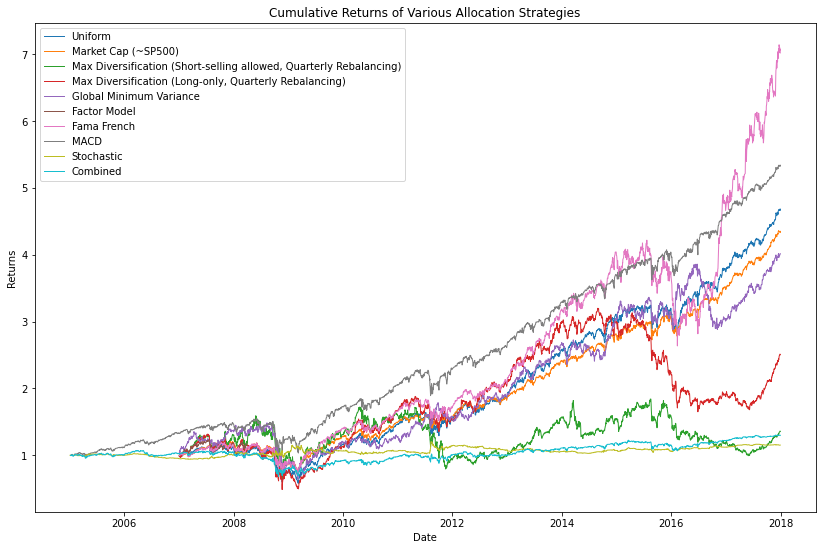

In [21]:
fig, ax = plt.subplots(figsize=(14, 9))

# Benchmarks
ax.plot(unif_cumulative_perf,                  linewidth=1.0, label="Uniform")
ax.plot(sp500_cumulative_perf,                 linewidth=1.0, label="Market Cap (~SP500)")

# Traditional Strategies
ax.plot(max_diverse_cumulative_perf,           linewidth=1.0, label="Max Diversification (Short-selling allowed, Quarterly Rebalancing)")
ax.plot(max_diverse_long_only_cumulative_perf, linewidth=1.0, label="Max Diversification (Long-only, Quarterly Rebalancing)")
ax.plot(gmv_cumulative_perf,                   linewidth=1.0, label="Global Minimum Variance")
ax.plot(fa_cumulative_perf,                    linewidth=1.0, label="Factor Model")
ax.plot(fama_cumulative_perf,                  linewidth=1.0, label="Fama French")

# Custom Strategies
ax.plot(macd_cumulative_perf,                  linewidth=1.0, label="MACD")
ax.plot(stochastic_cumulative_perf,            linewidth=1.0, label="Stochastic")
ax.plot(combined_cumulative_perf,              linewidth=1.0, label="Combined")

ax.set_title("Cumulative Returns of Various Allocation Strategies")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
ax.legend()
plt.show()